When I give talks about probabilistic programming and Bayesian statistics, I usually gloss over the details of how inference is actually performed, treating it as a black box essentially. The beauty of probabilistic programming is that you actually don't *have* to understand how the inference works in order to build models, but it certainly helps.

When I presented a new Bayesian model to [Quantopian's](https://quantopian.com) CEO, [Fawce](https://quantopian.com/about), who wasn't trained in Bayesian stats but is eager to understand it, he started to ask about the part I usually gloss over: "Thomas, how does the inference actually work? How do we get these magical samples from the posterior?". 

Now I could have said: "Well that's easy, MCMC generates samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. Questions?".

That statement is correct, but is it useful? My pet peeve with how math and stats are taught is that no one ever tells you about the intuition behind the concepts (which is usually quite simple) but only hands you some scary math. This is certainly the way I was taught and I had to spend countless hours banging my head against the wall until that euraka moment came about. Usually things weren't as scary or seemingly complex once I deciphered what it meant.

This blog post is an attempt at trying to explain the *intuition* behind MCMC sampling (specifically, the [random-walk Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)). Critically, we'll be using code examples rather than formulas or math-speak. Eventually you'll need that but I personally think it's better to start with the an example and build the intuition before you move on to the math.

## The problem and its unintuitive solution
Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

Now we might say "OK, if we can't solve something, could we try to approximate it? For example, if we could somehow draw samples from that posterior we can [Monte Carlo approximate](https://en.wikipedia.org/wiki/Monte_Carlo_method) it." Unfortunately, to directly sample from that distribution you not only have to solve Bayes formula, but also invert it, so that's even harder. 

Then we might say "Well, instead let's construct an ergodic, reversible Markov chain that has as an equilibrium distribution which matches our posterior distribution". I'm just kidding, most people wouldn't say that as it sounds bat-shit crazy. If you can't compute it, can't sample from it, then constructing that Markov chain with all these properties must be even harder.

The surprising insight though is that this is actually very easy and there exist a general class of algorithms that do this called [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (constructing a Markov chain to do Monte Carlo approximation).

## Setting up the problem

First, lets import our modules.

In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Lets generate some data: 20 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean `mu` (we'll assume that we know the standard deviation to be 1).

In [3]:
data = np.random.randn(20)

c:\program files (x86)\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


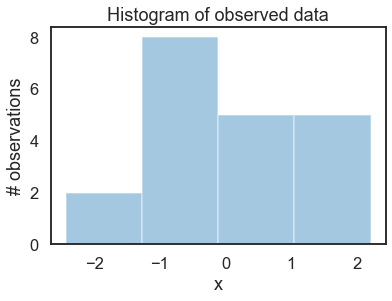

In [4]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Next, we have to define our model. In this simple case, we will assume that this data is normal distributed, i.e. the likelihood of the model is normal. As you know, a normal distribution has two parameters -- mean $\mu$ and standard deviation $\sigma$. For simplicity, we'll assume we know that $\sigma = 1$ and we'll want to infer the posterior for $\mu$. For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume  a Normal distribution as a prior for $\mu$. Thus, in stats speak our model is:

$$\mu \sim \text{Normal}(0, 1)\\
x|\mu \sim \text{Normal}(x; \mu, 1)$$

What is convenient, is that for this model, we actually can compute the posterior analytically. That's because for a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior) (conjugate here means that our posterior will follow the same distribution as the prior), so we know that our posterior for $\mu$ is also normal. We can easily look up on wikipedia how we can compute the parameters of the posterior. For a mathemtical derivation of this, see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM).

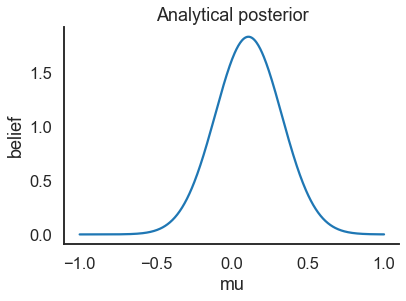

In [5]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

This shows our quantity of interest, the probability of $\mu$'s values after having seen the data, taking our prior information into account. Lets assume, however, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case.

## Explaining MCMC sampling with code

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

```python
mu_current = 1.
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current `mu` value (i.e. `mu_current`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here we're use `scipy.stats.norm`):

```python
proposal = norm(mu_current, proposal_width).rvs()
```

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed `mu` explaines the data better than your old `mu`, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed `mu` and a fixed `sigma = 1`). This can easily be computed by calculating the probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data)` and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has higher likelihood than `mu_current`. Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. You can already see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

This simple procedure gives us samples from the posterior.

### Why does this make sense?
Taking a step back, note that the above acceptance ratio is the reason this whole thing works out and we get around the integration. We can show this by computing the acceptance ratio over the normalized posterior and seeing how it's equivalent to the acceptance ratio of the unnormalized posterior (lets say $\mu_0$ is our current position, and $\mu$ is our proposal):

$$ \frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu) P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ -- that nasty quantity we can't compute -- gets canceled out. So you can intuit that we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability *relatively* more often than those of low posterior probability.

### Putting it all together

In [6]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

## Visualizing MCMC

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

The first columns is our prior distribution -- what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red or green (rejected or accepted, respectively). 

The 2nd column is our likelihood and what we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`.

The 3rd column is our posterior distribution. Here I am displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

The 4th column is our trace (i.e. the posterior samples of $\mu$ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).

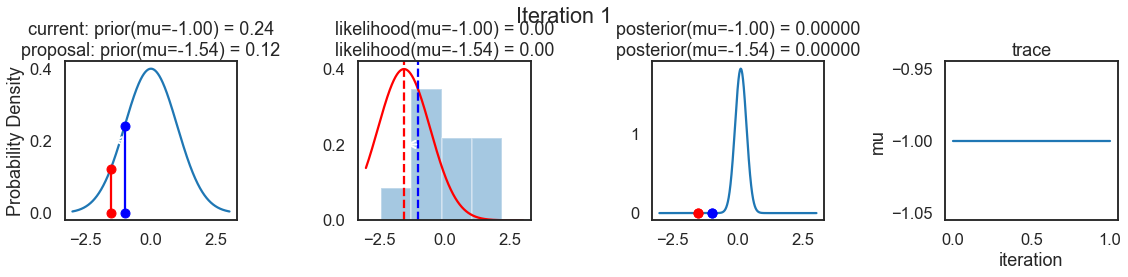

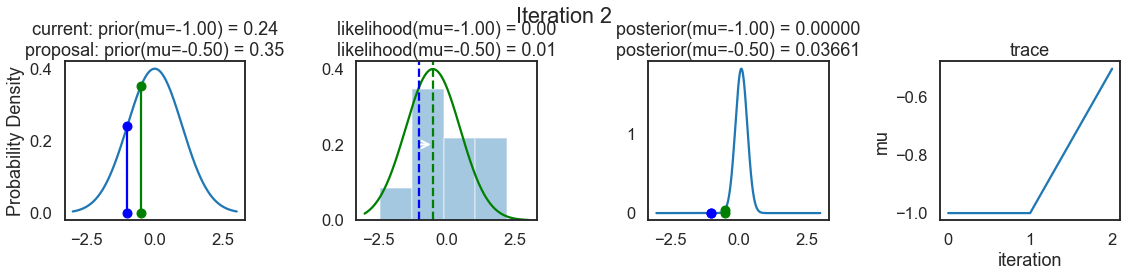

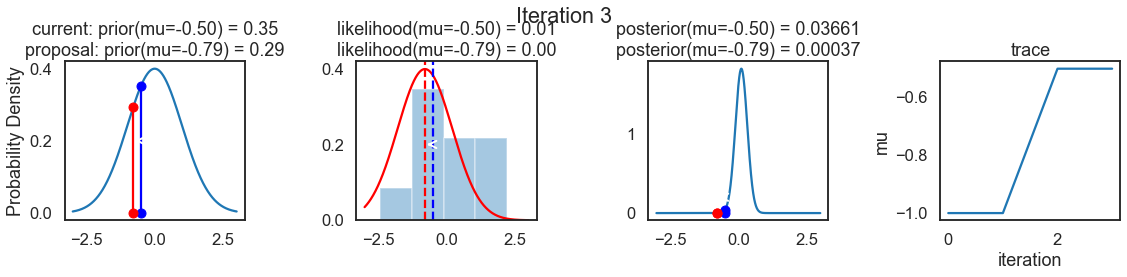

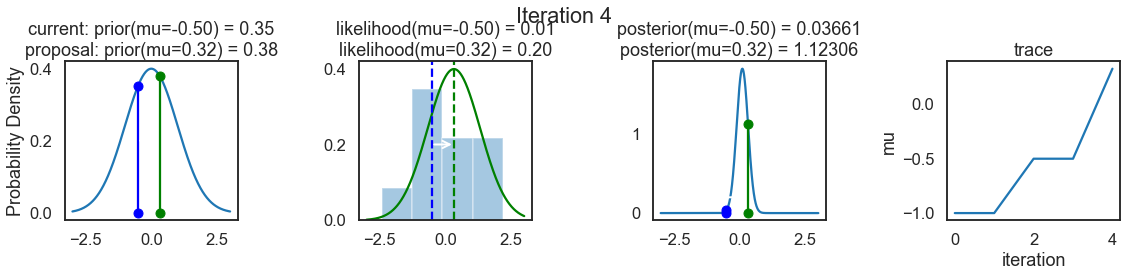

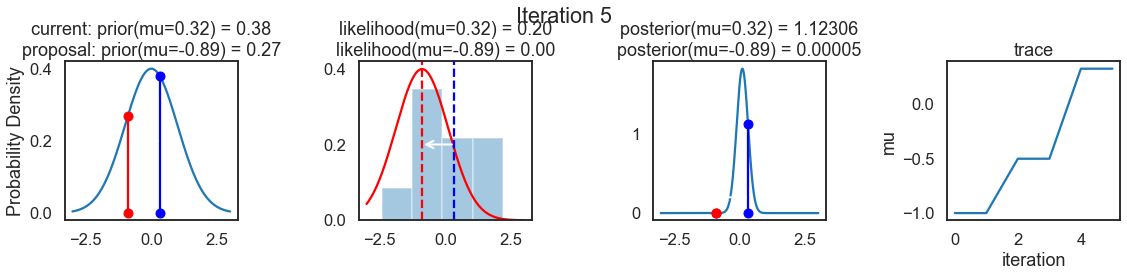

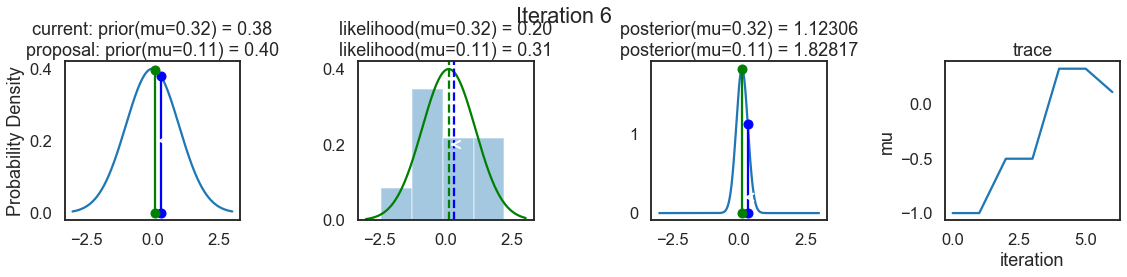

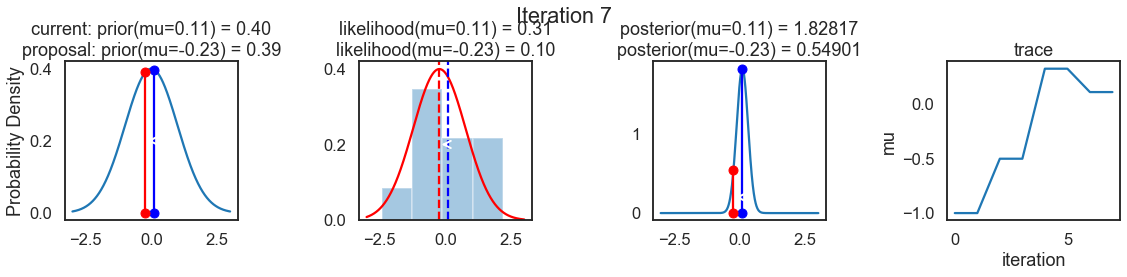

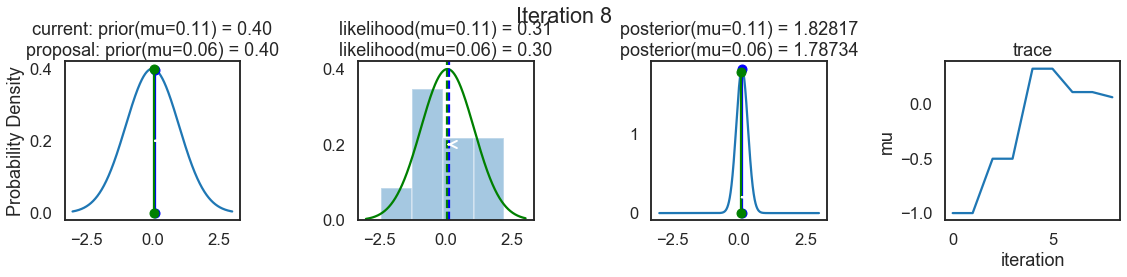

In [7]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this which I won't go into detail here.

To get a sense of what this produces, lets draw a lot of samples and plot them.

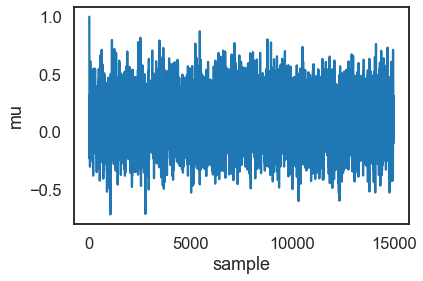

In [8]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This is usually called the trace. To now get an approximation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. It's important to keep in mind that although this looks similar to the data we sampled above to fit the model, the two are completely separate. The below plot represents our **belief** in `mu`. In this case it just happens to also be normal but for a different model, it could have a completely different shape than the likelihood or prior.

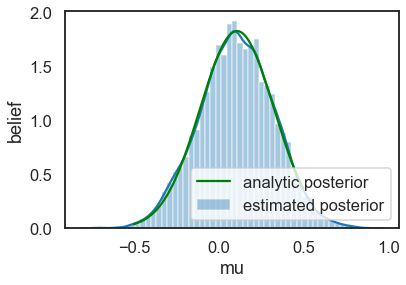

In [9]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

As you can see, by following the above procedure, we get samples from the same distribution as what we derived analytically.

## Proposal width

Above we set the proposal width to `0.5`. That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behavior:

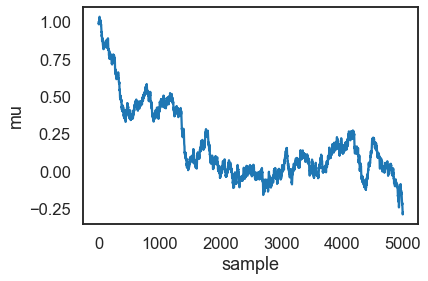

In [10]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

But you also don't want it to be so large that you never accept a jump:

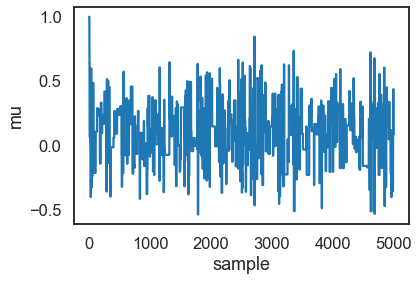

In [11]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

Note, however, that we are still sampling from our target posterior distribution here as guaranteed by the mathemtical proof, just less efficiently:

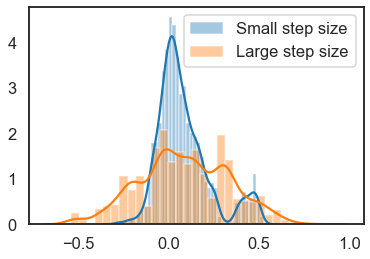

In [12]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

With more samples this will eventually look like the true posterior. The key is that we want our samples to be independent of each other which cleary isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample `i` is to sample `i-1`, `i-2`, etc:

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\program files (x86)\python37-32\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


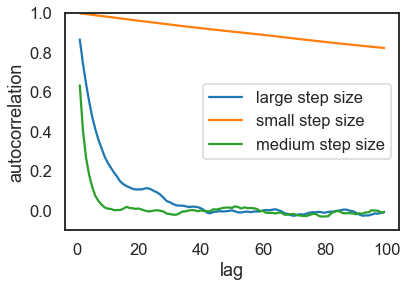

In [16]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Obviously we want to have a smart way of figuring out the right step width automatically. One common method is to keep adjusting the proposal width so that roughly 50% proposals are rejected.

## Extending to more complex models

Now you can easily imagine that we could also add a `sigma` parameter for the standard-deviation and follow the same procedure for this second parameter. In that case, we would be generating proposals for `mu` *and* `sigma` but the algorithm logic would be nearly identical. Or, we could have data from a very different distribution like a Binomial and still use the same algorithm and get the correct posterior. That's pretty cool and a huge benefit of probabilistic programming: Just define the model you want and let MCMC take care of the inference.

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results. Feel free to play around with this and change the distributions. For more information, as well as more complex examples, see the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/getting_started/).

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 62000/62000 [00:26<00:00, 2375.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
c:\program files (x86)\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


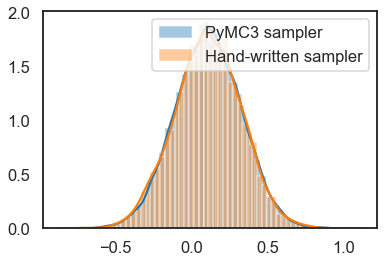

In [17]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

## Conclusions

We glossed over a lot of detail which is certainly important but there are many other posts that deal with that. Here, we really wanted to communicate the idea of MCMC and the Metropolis sampler. Hopefully you will have gathered some intuition which will equip you to read one of the more technical introductions to this topic.

Other, more fancy, MCMC algorithms like Hamiltonian Monte Carlo actually work very similar to this, they are just much more clever in proposing where to jump next.

This blog post was written in a Jupyter Notebook, you can find the underlying NB with all its code [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb).

## Support me on Patreon

Finally, if you enjoyed this blog post, consider [supporting me on Patreon](https://www.patreon.com/twiecki) which allows me to devote more time to writing new blog posts.